# MC Dropout with Fire Detection

## **1. Fire Detection Dataset 다운로드**

In [10]:
import os

os.system("kaggle datasets download atulyakumar98/test-dataset")
os.makedirs("data", exist_ok = True)
os.system("unzip test-dataset.zip -d ./data")
os.system("rm test-dataset.zip")

Dataset URL: https://www.kaggle.com/datasets/atulyakumar98/test-dataset
License(s): unknown


100%|██████████| 132M/132M [00:05<00:00, 25.6MB/s] 



Archive:  test-dataset.zip
  inflating: ./data/Fire-Detection/0/1.jpg  
  inflating: ./data/Fire-Detection/0/10.jpg  
  inflating: ./data/Fire-Detection/0/100.jpg  
  inflating: ./data/Fire-Detection/0/101.jpg  
  inflating: ./data/Fire-Detection/0/102.jpg  
  inflating: ./data/Fire-Detection/0/103.jpg  
  inflating: ./data/Fire-Detection/0/104.jpg  
  inflating: ./data/Fire-Detection/0/105.jpg  
  inflating: ./data/Fire-Detection/0/106.jpg  
  inflating: ./data/Fire-Detection/0/107.jpg  
  inflating: ./data/Fire-Detection/0/108.jpg  
  inflating: ./data/Fire-Detection/0/109.jpg  
  inflating: ./data/Fire-Detection/0/11.jpeg  
  inflating: ./data/Fire-Detection/0/110.jpg  
  inflating: ./data/Fire-Detection/0/111.jpg  
  inflating: ./data/Fire-Detection/0/112.jpg  
  inflating: ./data/Fire-Detection/0/113.jpg  
  inflating: ./data/Fire-Detection/0/114.jpg  
  inflating: ./data/Fire-Detection/0/115.jpg  
  inflating: ./data/Fire-Detection/0/116.jpg  
  inflating: ./data/Fire-Detection/

0

## **2. 훈련 데이터 분리 및 기초 통계량 확인**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

`-` 시드 설정 (재현성 확보)

In [136]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42
set_seed(seed_value)

`-` 이미지 데이터셋

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        root: 데이터셋 위치 폴더
        transform: torchvision.transforms.Compose 객체
        """
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_path = os.path.join(root, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  

        if self.transform:
            image = self.transform(image)

        return image, label

data_dir = 'data/Fire-Detection'

`-` Train/Test 데이터셋 분리 (8:2 stratified splitting)

In [217]:
tensor_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

origin_dataset = CustomImageDataset(root = data_dir, transform = tensor_transform)
labels = torch.tensor([label for _, label in origin_dataset])

train_ds, test_ds, train_label, test_label = train_test_split(origin_dataset, labels, test_size = 0.2, stratify = labels, random_state = 42)

`-` RGB 채널 별 기초통계량 및 픽셀 수 관련 통계량 계산

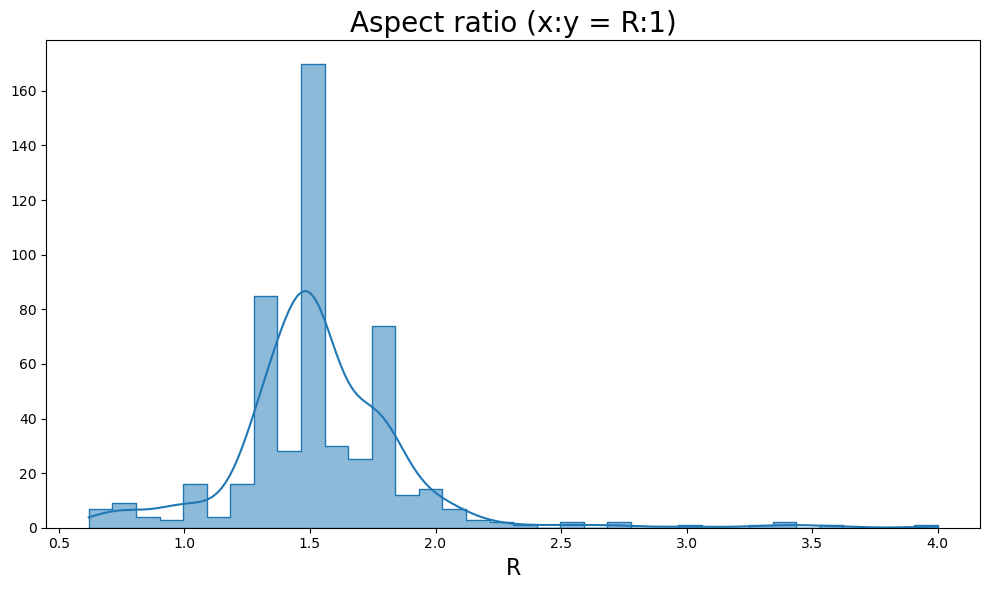

In [218]:
shape_list = [img[0].shape[1:] for img in train_ds]
y_axis, x_axis = torch.tensor(shape_list)[:, 0], torch.tensor(shape_list)[:, 1]
xy_ratio = x_axis/y_axis

## 종횡비 시각화
plt.figure(figsize=(10, 6))
sns.histplot(xy_ratio, kde = True, stat = "count",
             common_norm=False, element="step")
plt.title("Aspect ratio (x:y = R:1)", fontsize = 20)
plt.xlabel("R", fontsize = 16)
plt.ylabel(None)
plt.tight_layout()
plt.savefig("fig/xy_ratio.png", dpi = 300)

> 가로가 긴 사진이 더 많긴 하지만, 균일하지 않음. 정사각형으로 리사이즈하는 게 나을 것 같음

최소 픽셀 수: 180


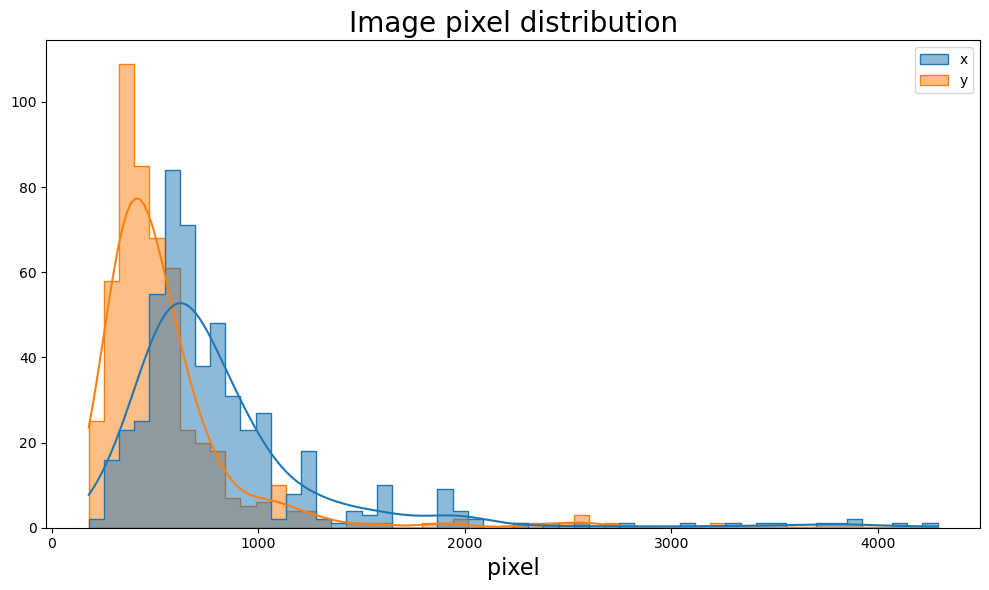

In [219]:
## 픽셀 수 시각화
tidy = pd.DataFrame(torch.tensor(shape_list))\
    .rename({0:"y", 1:"x"}, axis = 1).set_index("x").reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(data = tidy, kde = True, stat = "count",
             common_norm=False, element="step", alpha = 0.5)
plt.title("Image pixel distribution", fontsize = 20)
plt.xlabel("pixel", fontsize = 16)
plt.ylabel(None)
plt.tight_layout()
plt.savefig("fig/xy_pixel.png", dpi = 300)

min_pixel = torch.tensor(shape_list).min()

print(f"최소 픽셀 수: {min_pixel.int()}")

In [220]:
## 색상값 분포 (float)
origin_tensor = [img[0] for img in train_ds]

mean = []
std = []

for i in range(3):
    c = []

    for img in origin_tensor:
        c.append(img[i].flatten())

    c = torch.concat(c)
    mean.append(c.mean().item())
    std.append(c.std().item())

print(f"[R, G, B] channel mean: {[round(m, 4) for m in mean]}")
print(f"[R, G, B] channel std: {[round(s, 4) for s in std]}")

[R, G, B] channel mean: [0.4804, 0.4126, 0.3572]
[R, G, B] channel std: [0.2899, 0.2798, 0.2937]


`-` 데이터 전처리

In [6]:
mean = [0.4804, 0.4126, 0.3572]
std = [0.2899, 0.2798, 0.2937]
min_pixel = 180

## train dataset의 통계량으로 정규화하여 정보 유출 방지
transform = transforms.Compose([
    transforms.Resize((min_pixel, min_pixel)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

full_dataset = CustomImageDataset(root = data_dir, transform = transform)

labels = [label for _, label in full_dataset]
class_counts = Counter(labels)
print('Class Distribution:', class_counts)

Class Distribution: Counter({0: 541, 1: 110})


`-` Train/Valid/Test 데이터셋 분리 (7:1:2 stratified splitting)

In [7]:
train_ds, test_ds, train_label, test_label = train_test_split(full_dataset, labels, test_size = 0.2, stratify = labels, random_state = 42)
train_ds, valid_ds, train_label, valid_label = train_test_split(train_ds, train_label, test_size = 0.125, stratify = train_label, random_state = 42)

In [8]:
print(f"Full dataset size: {len(full_dataset)}")
print(f"Train dataset size: {len(train_ds)}")
print(f"Valid dataset size: {len(valid_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Full dataset size: 651
Train dataset size: 455
Valid dataset size: 65
Test dataset size: 131


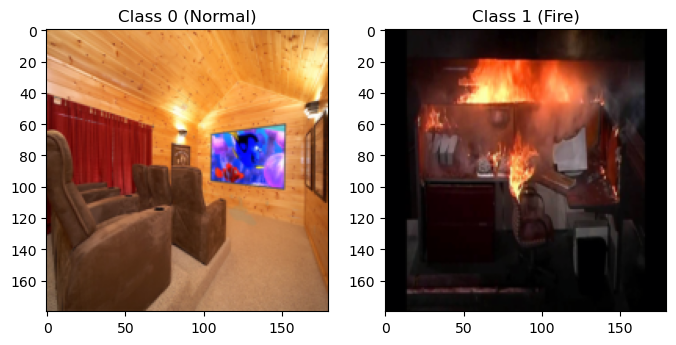

In [9]:
# 첫 번째 이미지(정상)와 마지막 이미지(화재)꺼내서 보기
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

img_normal = inv_normalize(train_ds[0][0]).permute(1, 2, 0)
img_fire = inv_normalize(train_ds[-1][0]).permute(1, 2, 0)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_normal)
ax[0].set_title("Class 0 (Normal)")
ax[1].imshow(img_fire)
ax[1].set_title("Class 1 (Fire)")
plt.show()

## 3. Baseline CNN

In [141]:
set_seed(seed_value)

`-` 하이퍼 파라미터 세팅

In [137]:
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.002
PATIENCE = 20

`-` 데이터 로더 세팅

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size = BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE)

`-` CNN 네트워크 설계

In [142]:
device = torch.device("cuda:0")

## 네트워크 설계
net = torch.nn.Sequential(
    #[Layer 1] Input: 3 x 180 x 180
    torch.nn.Conv2d(3, 64, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 64 x 60 x 60
    #[Layer 2]
    torch.nn.Conv2d(64, 256, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 256 x 20 x 20
    #[Layer 3]
    torch.nn.Conv2d(256, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 2), # -> 512 x 10 x 10
    #[Layer 4]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    #[Layer 5]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    #[Layer 6]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),

    torch.nn.AdaptiveAvgPool2d((1, 1)),  # -> 512 x 1
    torch.nn.Flatten(),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1)
).to(device)

Epoch 0 | train_loss: 0.5377	 valid_loss: 0.7750
Epoch 5 | train_loss: 0.1958	 valid_loss: 0.3508
Epoch 10 | train_loss: 0.0849	 valid_loss: 0.2066
Epoch 15 | train_loss: 0.1070	 valid_loss: 0.2958
Epoch 20 | train_loss: 0.0725	 valid_loss: 0.1566
Epoch 25 | train_loss: 0.0375	 valid_loss: 0.1740
Epoch 30 | train_loss: 0.0256	 valid_loss: 0.1428
Epoch 35 | train_loss: 0.0287	 valid_loss: 0.1284
Epoch 40 | train_loss: 0.0214	 valid_loss: 0.1454
Epoch 45 | train_loss: 0.0256	 valid_loss: 0.1424
Training Finished.


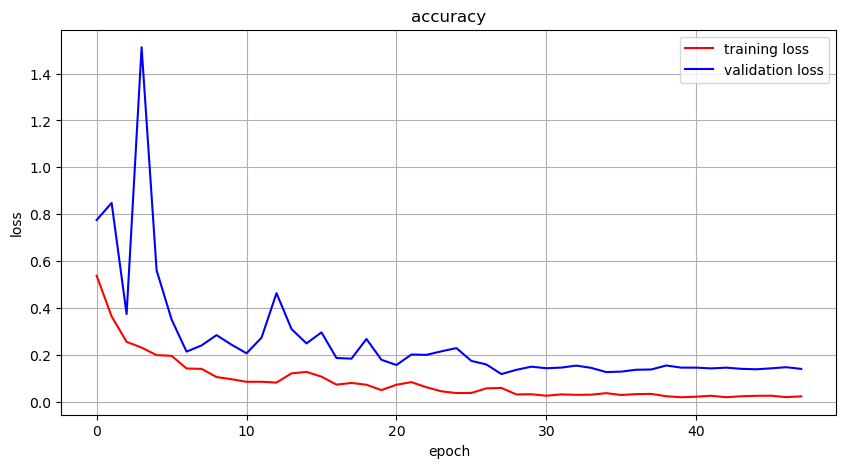

In [143]:
## 손실함수 및 옵티마이저
loss_fn = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(net.parameters(),
                        lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

## 학습
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
best_valid_loss = torch.inf
patience = 0
best_epoch = 0

for epoc in range(EPOCHS):
    net.train()
    s = 0
    train_loss = 0
    valid_loss = 0
    
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device).reshape(-1, 1).float()
        
        #업데이트
        netout = net(X)
        loss = loss_fn(netout, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() * X.size(0)
        s += ((netout > 0.0).squeeze() == y.squeeze()).sum()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = (s / len(train_dataloader.dataset)).item()

    net.eval()

    with torch.no_grad():
        s = 0

        for XX, yy in valid_dataloader:
            XX = XX.to(device)
            yy = yy.to(device).reshape(-1, 1).float()

            netout = net(XX)
            loss = loss_fn(netout, yy)
            valid_loss += loss.item() * XX.size(0)
            s += ((netout > 0.0).squeeze() == yy.squeeze()).sum()

        valid_loss = valid_loss / len(valid_dataloader.dataset)
        valid_acc = (s / len(valid_dataloader.dataset)).item()

        train_acc_history.append(avg_train_acc)
        train_loss_history.append(avg_train_loss)
        valid_acc_history.append(valid_acc)
        valid_loss_history.append(valid_loss)

    scheduler.step(valid_loss)

    if epoc % 5 == 0:
        print(f"Epoch {epoc} | train_loss: {avg_train_loss:.4f}\t valid_loss: {valid_loss:.4f}")

    # Best Model 저장 기능 (선택사항)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoc
        torch.save(net.state_dict(), 'baseline_best.pth')
        patience = 0

    else:
        patience += 1

        if patience >= PATIENCE:
            break

print("Training Finished.")

## 결과 확인
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='training loss', color='red')
plt.plot(valid_loss_history, label='validation loss', color='blue')
plt.title("accuracy")
plt.xlabel("epoch") 
plt.ylabel("loss")
plt.grid(True)
plt.legend()
plt.show()

In [145]:
## 테스트 데이터셋 정확도 확인
net.load_state_dict(torch.load("baseline_best.pth", weights_only=True))

net.eval()
s = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        
        netout = net(X)
        s += ((netout > 0.0).int().flatten() == y).sum().item()

    test_acc = s / len(test_dataloader.dataset)

print(f"\n테스트 정확도: {test_acc:.4f}")


테스트 정확도: 0.9847


* 최대 점수: 0.9847 (42 seed)

## MC dropout

In [150]:
NUM_MC_SAMPLES = 100

In [147]:
device = torch.device("cuda:0")

## 네트워크 설계
net = torch.nn.Sequential(
    #[Layer 1] Input: 3 x 180 x 180
    torch.nn.Conv2d(3, 64, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 64 x 60 x 60
    #[Layer 2]
    torch.nn.Conv2d(64, 256, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 256 x 20 x 20
    #[Layer 3]
    torch.nn.Conv2d(256, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 2), # -> 512 x 10 x 10
    #[Layer 4]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    #[Layer 5]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    #[Layer 6]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),

    torch.nn.AdaptiveAvgPool2d((1, 1)),  # -> 512 x 1
    torch.nn.Flatten(),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1)
).to(device)

net.load_state_dict(torch.load("baseline_best.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
# Source - https://stackoverflow.com/a
# Posted by Iswariya Manivannan, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-09, License - CC BY-SA 4.0

import sys

import numpy as np

import torch
import torch.nn as nn

def enable_dropout(model):
    """
    Function to enable the dropout layers during test-time
    
    모델에 Batch Normalization이 있으므로 전체를 train으로 하지 말고 Dropout 레이어만 train 모드로
    """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_binary_predictions(data_loader,
                                       forward_passes,
                                       model,
                                       n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    약간 개조했음...

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((0, n_samples, 1))
    
    for _ in range(forward_passes):
        predictions = np.empty((0, 1))
        model.eval()
        enable_dropout(model)   ## setting train mode (dropout only)
        for _, (image, _) in enumerate(data_loader):
            image = image.to(torch.device('cuda'))

            with torch.no_grad():
                netout = model(image)
                output = torch.sigmoid(netout)

            predictions = np.vstack((predictions, output.cpu().numpy()))

        dropout_predictions = np.vstack((dropout_predictions,
                                         predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)

    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes 
    variance = np.var(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    return mean, variance

In [ ]:
mean, variance = get_monte_carlo_binary_predictions(test_dataloader, NUM_MC_SAMPLES, net, len(test_dataloader.dataset))

In [190]:
((mean > 0.5).squeeze() == torch.tensor(test_label)).float().mean()

tensor(0.9847)

In [175]:
torch.tensor(test_label)

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        
        netout = net(X)
        s += ((netout > 0.0).int().flatten() == y).sum().item()

    test_acc = s / len(test_dataloader.dataset)

print(f"\n테스트 정확도: {test_acc:.4f}")

* 해결해야 할 사항
1. 시드에 따라 크게 달라지는 결과
2. Test dataset에서 퍼포먼스 변화 없음